In [1]:
import cv2 as cv
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

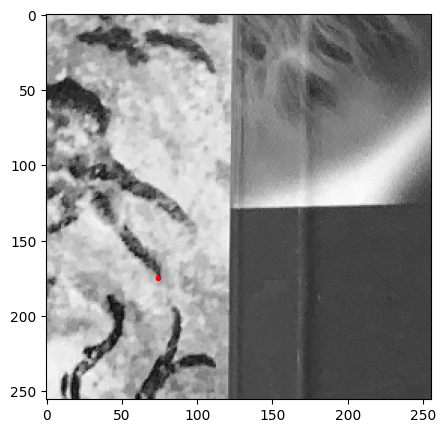

In [2]:
DATA_FOLDER = 'data'
img = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img = cv.resize(img, (256, 256))

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.plot([74],[175],'r.');

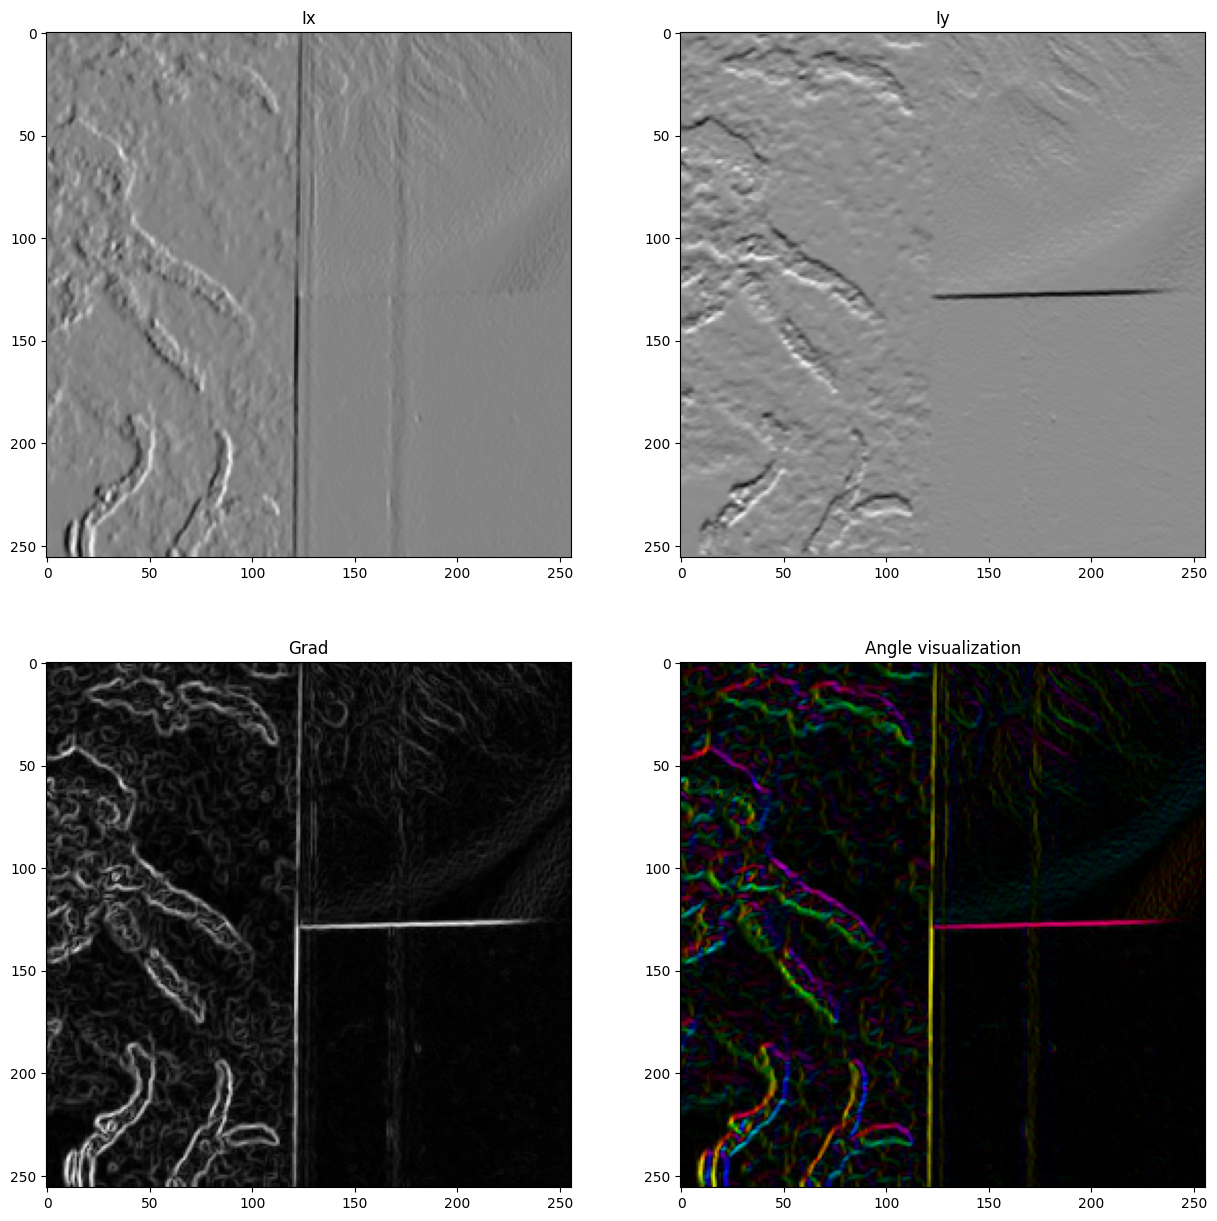

In [3]:
# Image derivatives
Ix = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
Iy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

# Gradient magnitude and angle direction using colors
Igrad = np.sqrt(np.square(Ix) + np.square(Iy))
Igrad_c = np.zeros([img.shape[0], img.shape[0],3], dtype=np.uint8)
Igrad_c[..., 1] = 255
mag, ang = cv.cartToPolar(Ix[...], Iy[...])
Igrad_c[..., 0] = ang * 180 / np.pi / 2
Igrad_c[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
Igrad_color = cv.cvtColor(Igrad_c, cv.COLOR_HSV2BGR)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Ix')
plt.imshow(Ix, cmap='gray')
plt.subplot(222)
plt.title('Iy')
plt.imshow(Iy, cmap='gray');
plt.subplot(223)
plt.title('Grad')
plt.imshow(Igrad, cmap='gray')
plt.subplot(224)
plt.title('Angle visualization')
plt.imshow(Igrad_color);

In [4]:
def draw_rect(cx, cy, w, h, color='red', width=4):
    """
    Requires `import matplotlib as mpl`
    """
    ax = plt.gca()

    t, b = cy-h//2, cy+h//2
    l, r = cx-w//2, cx+w//2
       
    rect = mpl.lines.Line2D([l,l,r,r,l],[t,b,b,t,t],color=color,linewidth=width)
    ax.add_line(rect)
    return int(t), int(b), int(l), int(r)

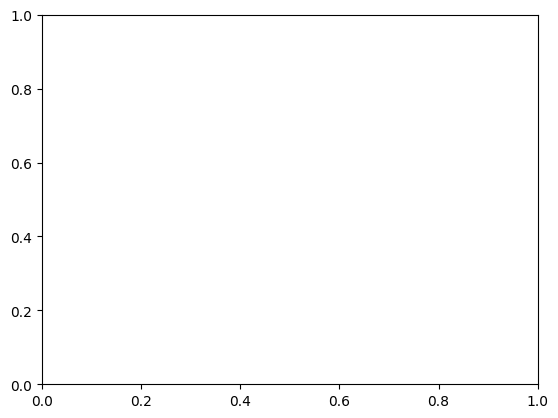

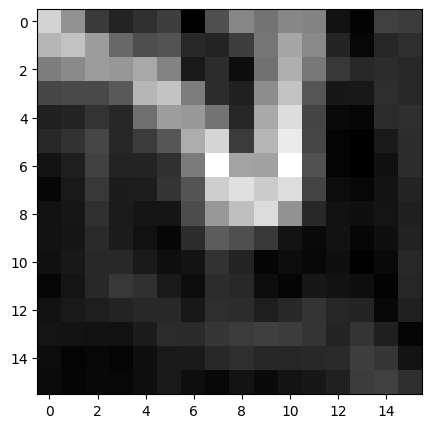

In [5]:
cx, cy, w, h = 74, 175, 16, 16
t, b, l, r = draw_rect(cx, cy, w, h)
grad_patch = Igrad[t:b,l:r]

plt.figure(figsize=(5,5))
plt.imshow(grad_patch, cmap='gray');

In [6]:
def gaussian2_xy(mean, cov, xy):
    invcov = np.linalg.inv(cov)
    results = np.ones([xy.shape[0], xy.shape[1]])
    for x in range(0, xy.shape[0]):
        for y in range(0, xy.shape[1]):
            v = xy[x,y,:].reshape(2,1) - mean
            results[x,y] = np.dot(np.dot(np.transpose(v), invcov), v)
    results = np.exp( - results / 2 )
    return results 

def gaussian2_n(mean, cov, n):
    s = n//2
    x = np.linspace(-s,s,n)
    y = np.linspace(-s,s,n)
    xc, yc = np.meshgrid(x, y)
    xy = np.zeros([n, n, 2])
    xy[:,:,0] = xc
    xy[:,:,1] = yc

    return gaussian2_xy(mean, cov, xy), xc, yc

def gaussian2d(var, n):
    mean =  np.array([0, 0])
    mean = mean.reshape(2,1)
    cov = np.array([[var,0],[0,var]])
    k, xc, yc = gaussian2_n(mean, cov, n)
    return k
 

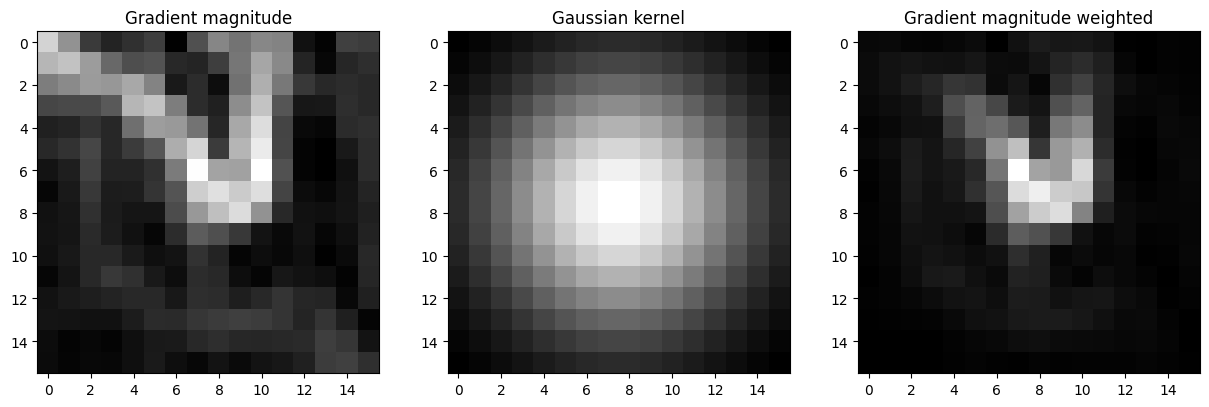

In [7]:
g = gaussian2d(20, 16)

grad_patch_weighted = grad_patch * g

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Gradient magnitude')
plt.imshow(grad_patch, cmap='gray')
plt.subplot(132)
plt.title('Gaussian kernel')
plt.imshow(g, cmap='gray')
plt.subplot(133)
plt.title('Gradient magnitude weighted')
plt.imshow(grad_patch_weighted, cmap='gray');

In [8]:
# g = gaussian2d(6, 16)

# def my_local_descriptor(img, r, c):
#     cx, cy, w, h = c, r, 16, 16
#     t, b, l, r = draw_rect(cx, cy, w, h)
#     I_patch = img[t:b,l:r]

#     Ix = cv.Sobel(I_patch, cv.CV_64F, 1, 0, ksize=7)
#     Iy = cv.Sobel(I_patch, cv.CV_64F, 0, 1, ksize=7)

#     grad_patch = np.sqrt(np.square(Ix) + np.square(Iy))

#     grad_patch_weighted = np.multiply(grad_patch, g)

#     Igrad_c = np.zeros([I_patch.shape[0], I_patch.shape[0],3], dtype=np.uint8)
#     Igrad_c[..., 1] = 255
#     mag, ang = cv.cartToPolar(Ix[...], Iy[...])
#     Igrad_c[..., 0] = ang * 180 / np.pi / 2
#     Igrad_c[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
#     grad_color_patch = cv.cvtColor(Igrad_c, cv.COLOR_HSV2BGR)

#     Iangle_patch = np.mod(np.arctan2(Iy, Ix)*(180.0/np.pi), 360)
#     Iangle_patch_flat = Iangle_patch.ravel()
#     Iangle_patch_used = Iangle_patch_flat[Iangle_patch_flat != 0.0]
#     angle_bins = np.linspace(0, 360, 36+1)
#     angle_counts, _ = np.histogram(Iangle_patch_used, angle_bins)
#     dominant_angle = np.where(angle_counts == np.max(angle_counts))[0][0]*(360/36)
#     print('Dominant angle = {} degrees'.format(dominant_angle))
#     Iangle_patch_rotation_invariant = np.mod(np.subtract(Iangle_patch, dominant_angle), 360)

#     h, w = I_patch.shape
#     Iangle_blocks = (Iangle_patch_rotation_invariant.reshape(h//4, 4, -1, 4).swapaxes(1, 2).reshape(-1, 4, 4))
#     vectors = []
#     for Iangle_block in Iangle_blocks:
#         Iangle_block_flat = Iangle_block.ravel()
#         Iangle_block_used = Iangle_block_flat[Iangle_block_flat != 0.0]
#         angle_bins = np.linspace(0, 360, 8+1)
#         angle_counts, _ = np.histogram(Iangle_block_used, angle_bins)
#         vectors.append(angle_counts)
#     descriptor = [j for i in vectors for j in i]
    
#     return descriptor, I_patch, grad_patch, grad_patch_weighted, grad_color_patch

In [9]:
g = gaussian2d(6, 16)

def my_local_descriptor(img, r, c):
    cx, cy, w, h = c, r, 16, 16
    t, b, l, r = draw_rect(cx, cy, w, h)

    Ix = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=7)
    Iy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=7)

    Igrad = np.sqrt(np.square(Ix) + np.square(Iy))
    # Iangle = np.mod(np.arctan2(Iy, Ix)*(180.0/np.pi), 360) # Convert from (-180 180) to (0 360)
    Iangle = np.arctan2(Iy, Ix)*(180.0/np.pi) + 180

    Igrad_c = np.zeros([img.shape[0], img.shape[0],3], dtype=np.uint8)
    Igrad_c[..., 1] = 255
    mag, ang = cv.cartToPolar(Ix[...], Iy[...])
    Igrad_c[..., 0] = ang * 180 / np.pi / 2
    Igrad_c[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    Igrad_color = cv.cvtColor(Igrad_c, cv.COLOR_HSV2BGR)

    I_patch = img[t:b,l:r]
    grad_patch = Igrad[t:b,l:r]
    angle_patch = Iangle[t:b,l:r]
    grad_patch_weighted = grad_patch * g
    grad_color_patch = Igrad_color[t:b,l:r]

    angle_patch_flat = angle_patch.flatten()
    bins = np.linspace(0, 360, 36)
    quantized = np.digitize(angle_patch_flat, bins)
    counts = np.bincount(quantized)
    dominant_angle = np.argmax(counts)*(360/36)
    print('Dominant angle = {} degrees'.format(dominant_angle))
    angle_patch_rotation_invariant = angle_patch - dominant_angle
    # angle_patch_rotation_invariant = np.mod(angle_patch - dominant_angle, 360) # Convert from (-180 180) to (0 360)

    angle_patch_rotation_invariant_flat = angle_patch_rotation_invariant.flatten()
    bins = np.linspace(0, 360, 8)
    quantized = np.digitize(angle_patch_rotation_invariant_flat, bins)
    quantized_angle_patch_flat = np.zeros(len(quantized))
    for i in range(len(angle_patch_rotation_invariant_flat)):
        quantized_angle_patch_flat[i] = quantized[i]*(360/8)
    quantized_angle_patch = np.reshape(quantized_angle_patch_flat, (-1, 16))

    h, w = I_patch.shape
    quantized_angle_patch_blocks = (quantized_angle_patch.reshape(h//4, 4, -1, 4).swapaxes(1, 2).reshape(-1, 4, 4))
    grad_patch_weighted_blocks = (grad_patch_weighted.reshape(h//4, 4, -1, 4).swapaxes(1, 2).reshape(-1, 4, 4))
    vectors = []
    for i in range(len(grad_patch_weighted_blocks)):
        bins = np.linspace(0, 360, 8+1)
        h, _ = np.histogram(quantized_angle_patch_blocks[i], bins, weights=grad_patch_weighted_blocks[i], density=True)
        vectors.append(h)
    descriptor = [j for i in vectors for j in i]

    return descriptor, I_patch, grad_patch, grad_patch_weighted, grad_color_patch

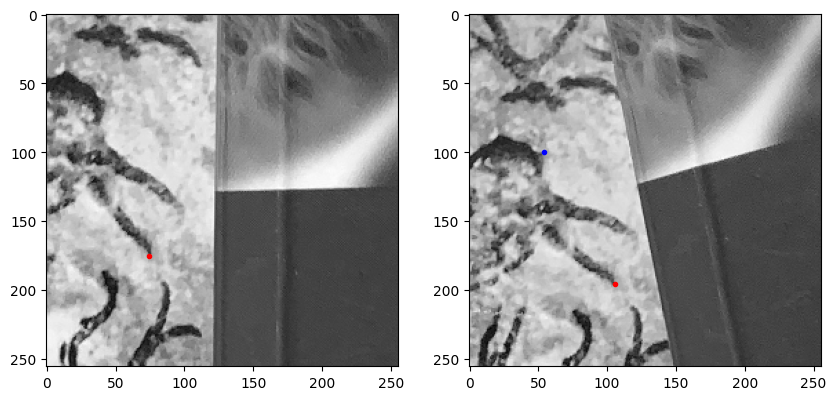

In [10]:
DATA_FOLDER = 'data'
img1 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-2.jpg'), 0)
img1 = cv.resize(img1, (256, 256))

img2 = cv.imread(os.path.join(DATA_FOLDER, 'local-features-construction-1.jpg'), 0)
img2 = cv.resize(img2, (256, 256))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img1, cmap='gray');
plt.plot([74],[175],'r.')
plt.subplot(122)
plt.imshow(img2, cmap='gray');
plt.plot([106],[196],'r.');
plt.plot([54],[100],'b.');

Dominant angle = 310.0 degrees
Dominant angle = 300.0 degrees
Dominant angle = 180.0 degrees


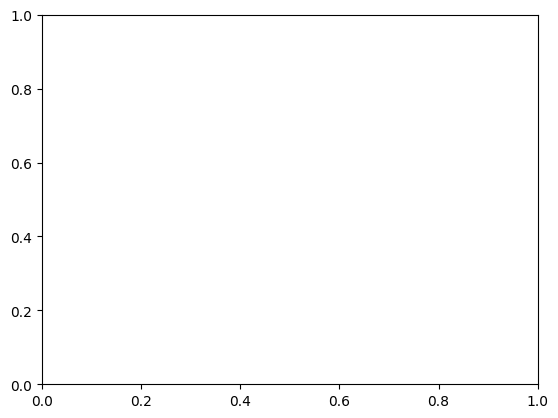

In [11]:
desc1, p1, g1, gw1, gc1 = my_local_descriptor(img1, 175, 74)
desc2, p2, g2, gw2, gc2 = my_local_descriptor(img2, 197, 106)
desc3, p3, g3, gw3, gc3 = my_local_descriptor(img2, 100, 54)

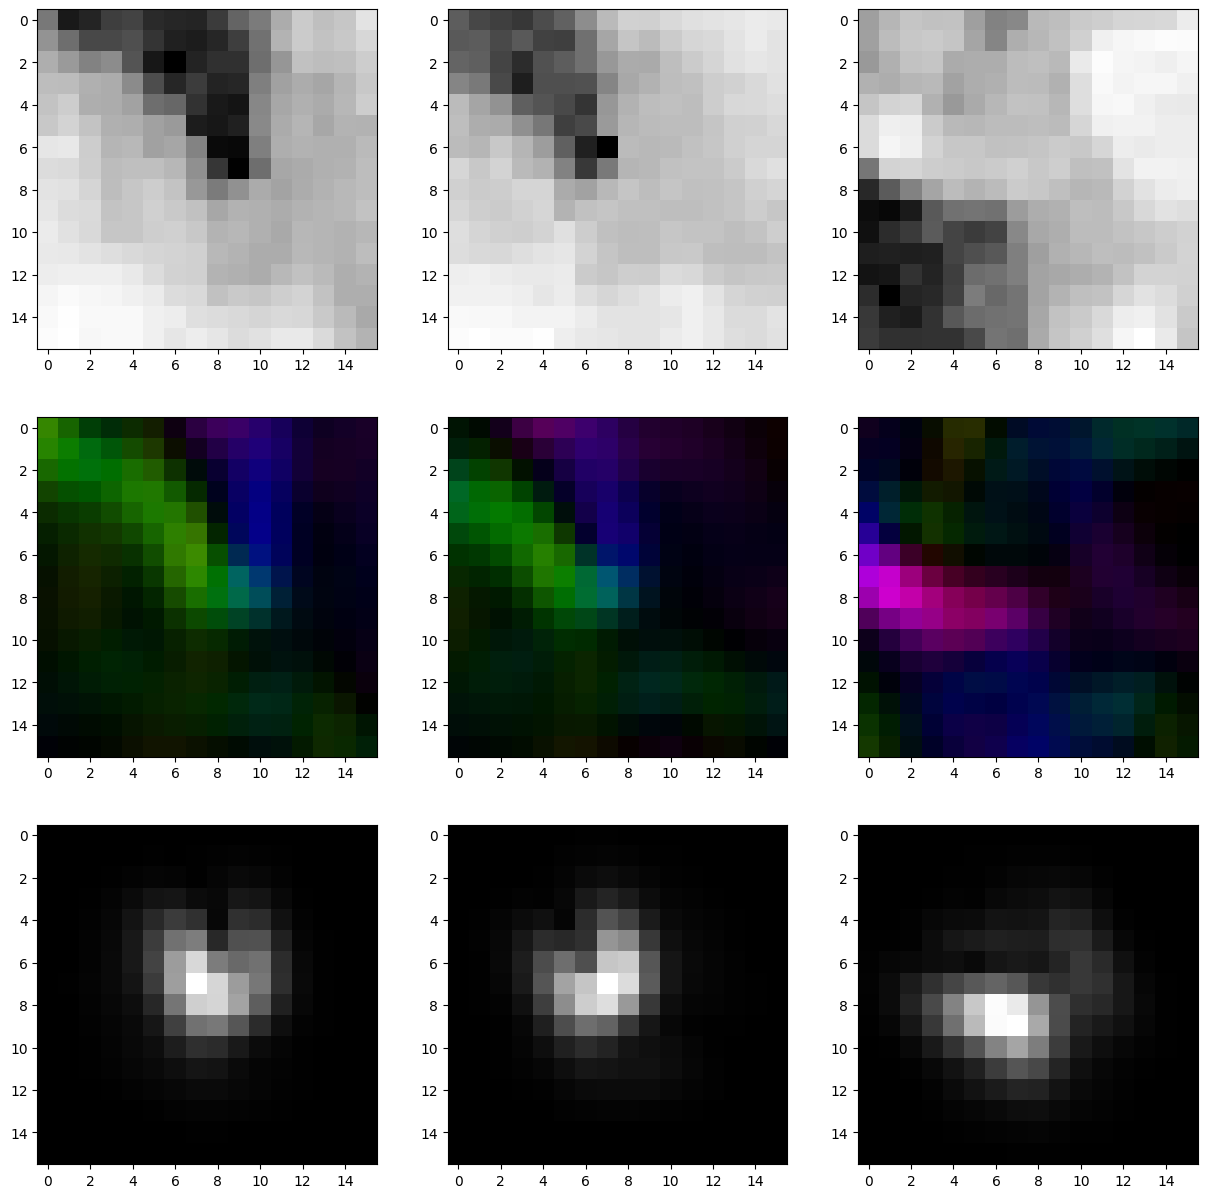

In [12]:
plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.imshow(p1, cmap='gray')
plt.subplot(332)
plt.imshow(p2, cmap='gray')
plt.subplot(333)
plt.imshow(p3, cmap='gray')
plt.subplot(334)
plt.imshow(gc1, cmap='gray')
plt.subplot(335)
plt.imshow(gc2, cmap='gray')
plt.subplot(336)
plt.imshow(gc3, cmap='gray')
plt.subplot(337)
plt.imshow(gw1, cmap='gray')
plt.subplot(338)
plt.imshow(gw2, cmap='gray')
plt.subplot(339)
plt.imshow(gw3, cmap='gray');

In [13]:
from scipy.spatial import distance_matrix

X = np.vstack([desc1, desc2, desc3])
distance_matrix(X, X)

array([[0.        , 0.04875871, 0.0714038 ],
       [0.04875871, 0.        , 0.06715097],
       [0.0714038 , 0.06715097, 0.        ]])